# **AIN 214 - PA5 - FALL 2024**





BELOW MD CELLS CONTAIN THE QUESTIONS YOU ARE ASKED TO IMPLEMENT WITHIN THE CONTEXT OF THIS HW. PLEASE FILL IN THE CELLS FOR THE ANSWERS RIGHT BELOW THE MD CELL OF THE QUESTION. YOU CAN ADD AS MANY CELLS AS YOU WANT, BE IT CODE OR MD, SO LONG AS YOU PROVIDE UNDERSTANDABLE AND TRACEABLE REPORTING. PLEASE ADD COMMENTS ON YOUR CODES. ALSO, FILL IN MD CELLS WHERE YOU ARE ASKED TO COMMENT ON YOUR RESULTS OR EXPLAIN YOUR REASONING. ALSO, PLEASE DO NOT HESITATE TO USE THEM FOR YOUR OWN REPORTING PURPOSES. PLEASE KEEP IN MIND THAT, REPORTING IS A KEY STEP IN DATA SCIENCE.

**Deadline: 03.01.2025 (23:59:59)**

**Submission:** Submit your Jupyter Notebooks via https://submit.cs.hacettepe.edu.tr/

<font color='red'> **!!! PLEASE RUN YOUR CODE.   THE OUTPUT OF YOUR CODE MUST BE VISIBLE. DO NOT DELETE OR HIDE THE OUTPUT.**</font>



---


# **CLUSTERING**


This assignment aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering and explore the impact of PCA on these clustering techniques.

---
**Dataset Path:** "Data/wholesale_customers_data.csv"
---

The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.

***Variables***

* FRESH: annual spending (m.u.) on fresh products (Continuous);
* MILK: annual spending (m.u.) on milk products (Continuous);
* GROCERY: annual spending (m.u.)on grocery products (Continuous);
* FROZEN: annual spending (m.u.)on frozen products (Continuous)
* DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
* DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
* CHANNEL: customers Channel - (Hotel/Restaurant/Cafe) (Nominal)
* REGION: customers Region  (Lisnon, Oporto or Other) (Nominal)




# **Necessary Imports**

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# **PART- 1: Data Preprocessing and Visualization (20 Pts)**

---

## 1.1. Explaratory Data Analysis (10 Pts)

* Analyze  the dataset and explain analysis results
* Check and handle missing values and outliers
* Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.



#### Quick look
- All columns are numeric

In [22]:
df = pd.read_csv('Data/wholesale_customers_data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


There are 11 columns and 440 rows.

In [23]:
df.shape

(440, 8)

There aren't any nan value.

In [24]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

There aren't any columns with negative value which is good since any column cannot take negative values.

In [25]:
for numeric_column in df.select_dtypes(include='number').columns:
    if (df[numeric_column] < 0).any():
        print(f"Column '{numeric_column}' contains negative values.")
    else:
        print(f"Column '{numeric_column}' does not contain negative values.")

Column 'Channel' does not contain negative values.
Column 'Region' does not contain negative values.
Column 'Fresh' does not contain negative values.
Column 'Milk' does not contain negative values.
Column 'Grocery' does not contain negative values.
Column 'Frozen' does not contain negative values.
Column 'Detergents_Paper' does not contain negative values.
Column 'Delicassen' does not contain negative values.


There are at most 2 channels and 3 regions in this dataset. In order to understand whether records are evenly clustered in these classes, the distributions can be viewed.

In [26]:
def find_max_min_range(df):
    max = df.max()
    min = df.min()
    range = max - min
    print(f"Column {df.name} -> Max: {max}, Min: {min}, Range: {range}")


df.agg(find_max_min_range)
print()

Column Channel -> Max: 2, Min: 1, Range: 1
Column Region -> Max: 3, Min: 1, Range: 2
Column Fresh -> Max: 112151, Min: 3, Range: 112148
Column Milk -> Max: 73498, Min: 55, Range: 73443
Column Grocery -> Max: 92780, Min: 3, Range: 92777
Column Frozen -> Max: 60869, Min: 25, Range: 60844
Column Detergents_Paper -> Max: 40827, Min: 3, Range: 40824
Column Delicassen -> Max: 47943, Min: 3, Range: 47940


There are outliers in this dataset. Handling and smoothing the extreme ones is necessary for a better result. 

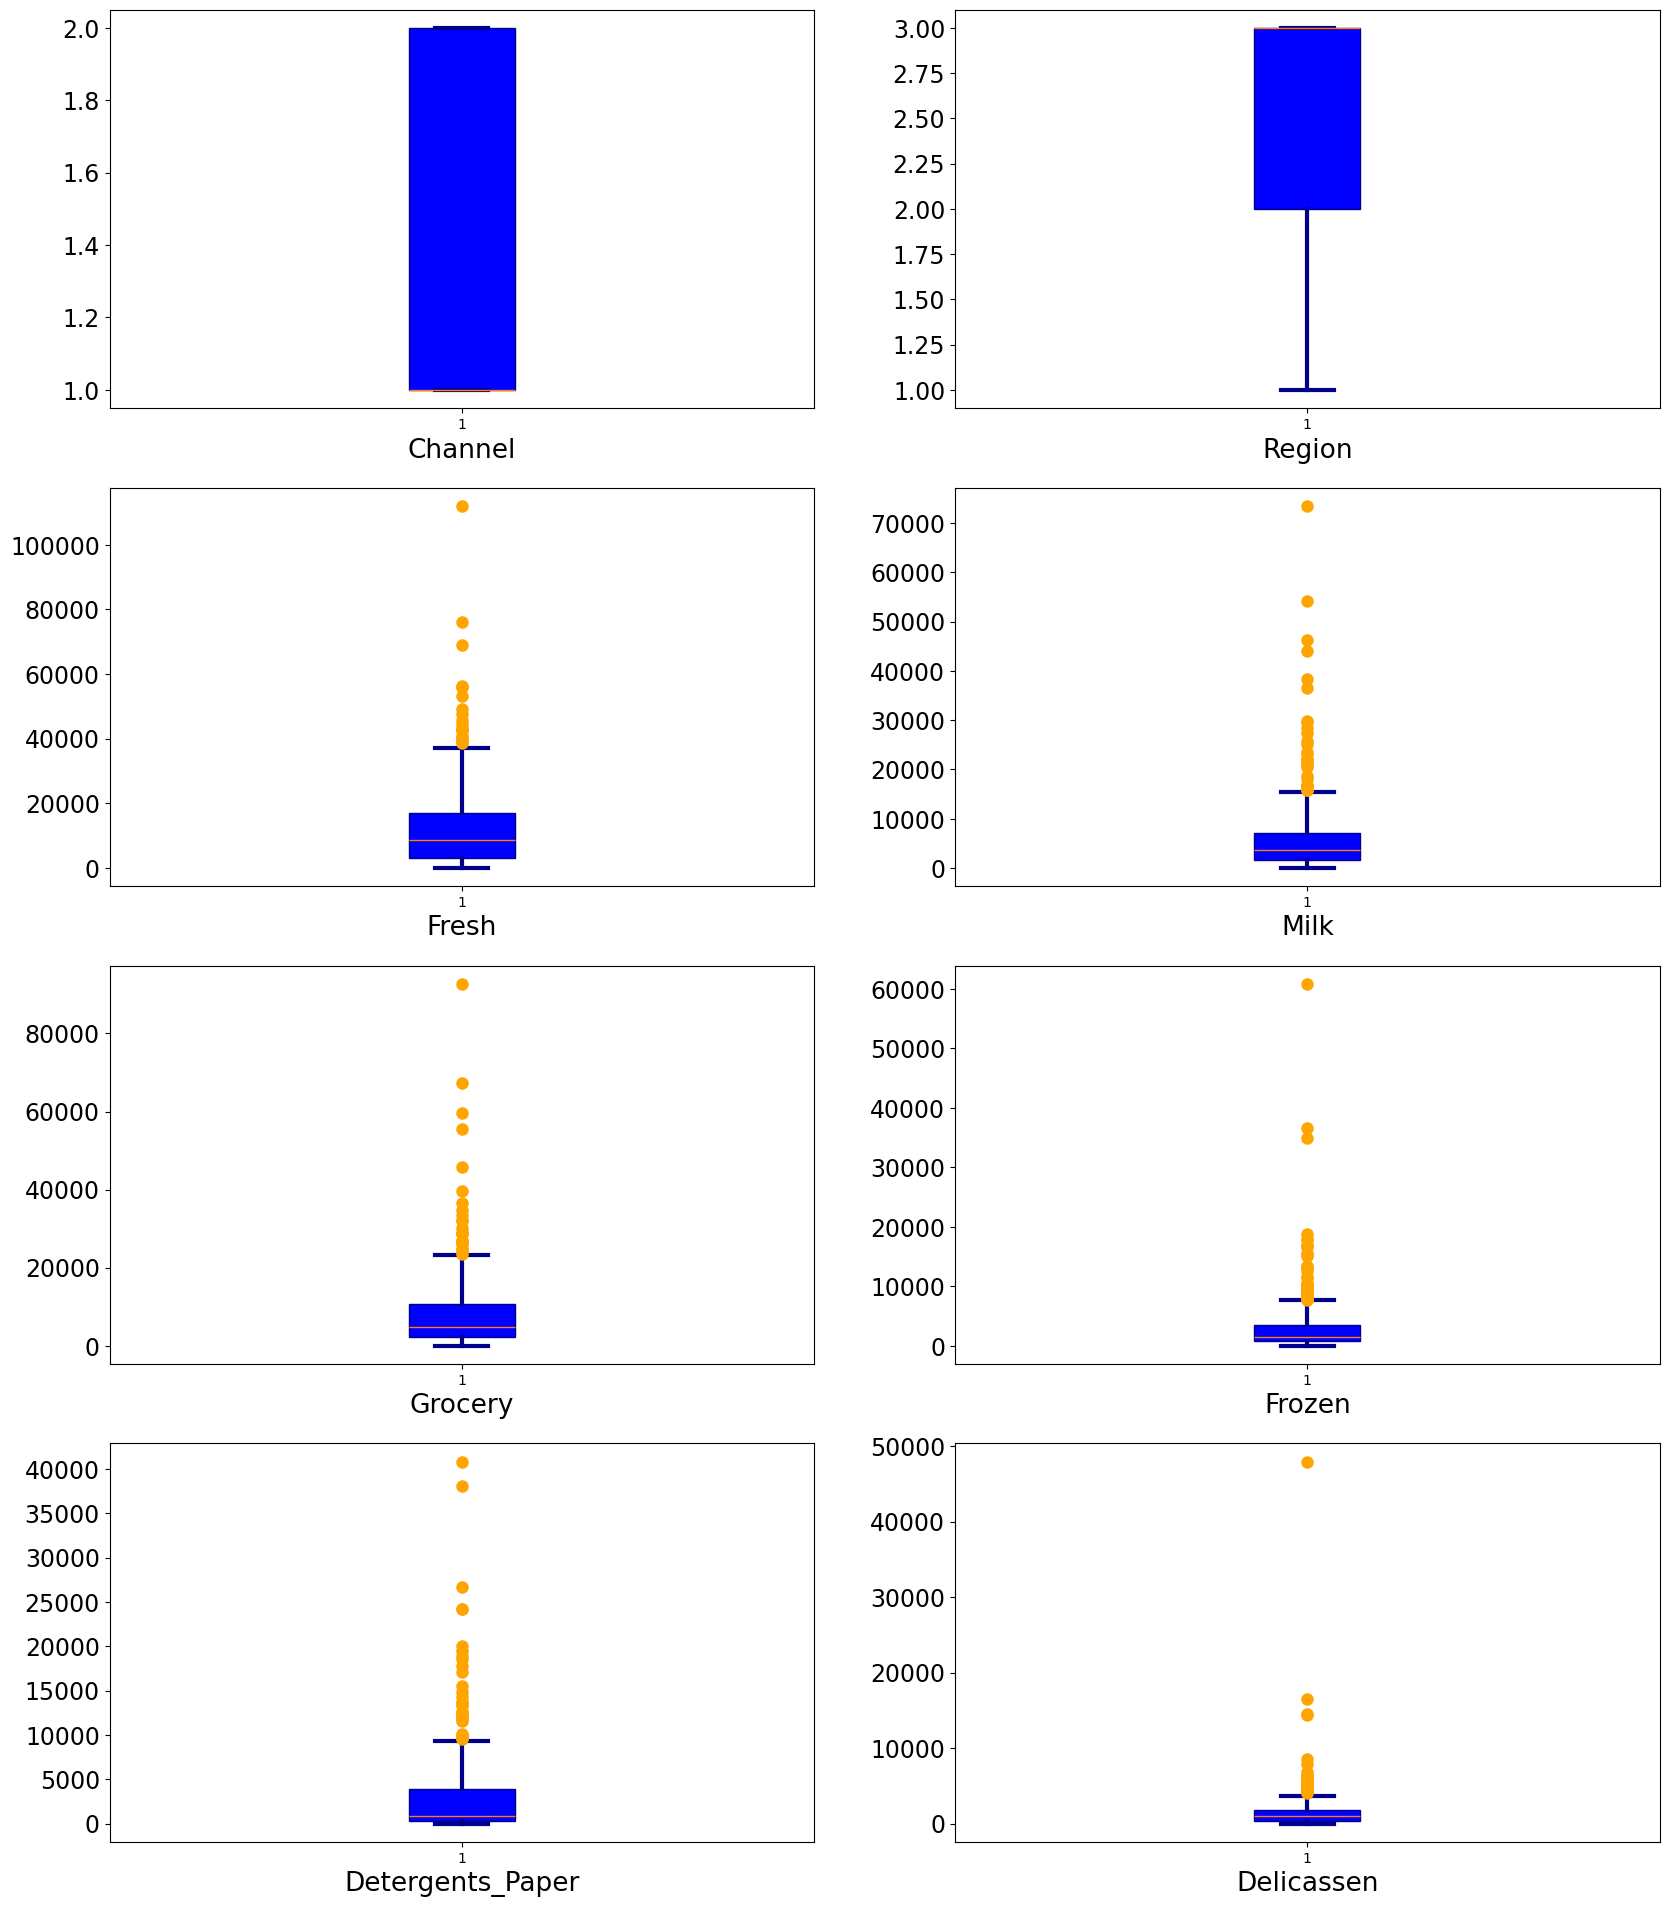

In [27]:
def show_boxplot_distribution(df):
    numeric_columns = df.select_dtypes(include='number').columns
    plt.figure(figsize=(20, 30))
    for i, column in enumerate(numeric_columns, 1):
        plt.subplot((len(numeric_columns) + 2) // 2, 2, i)
        plt.boxplot(x=df[column],
                    patch_artist=True,
                    boxprops=dict(facecolor='blue', color='darkblue'),
                    whiskerprops=dict(color="darkblue", linewidth=3),
                    flierprops=dict(markerfacecolor='orange', marker='o', markersize=8, markeredgecolor='orange'),
                    capprops=dict(color='darkblue', linewidth=3))
        plt.xlabel(column, fontsize=19)
        plt.yticks(fontsize=17)
    plt.show()
    

show_boxplot_distribution(df)

Outliers are imputed with median. As visible in the plots after imputation, extreme values are imputed while there are still values outside of whiskers. 

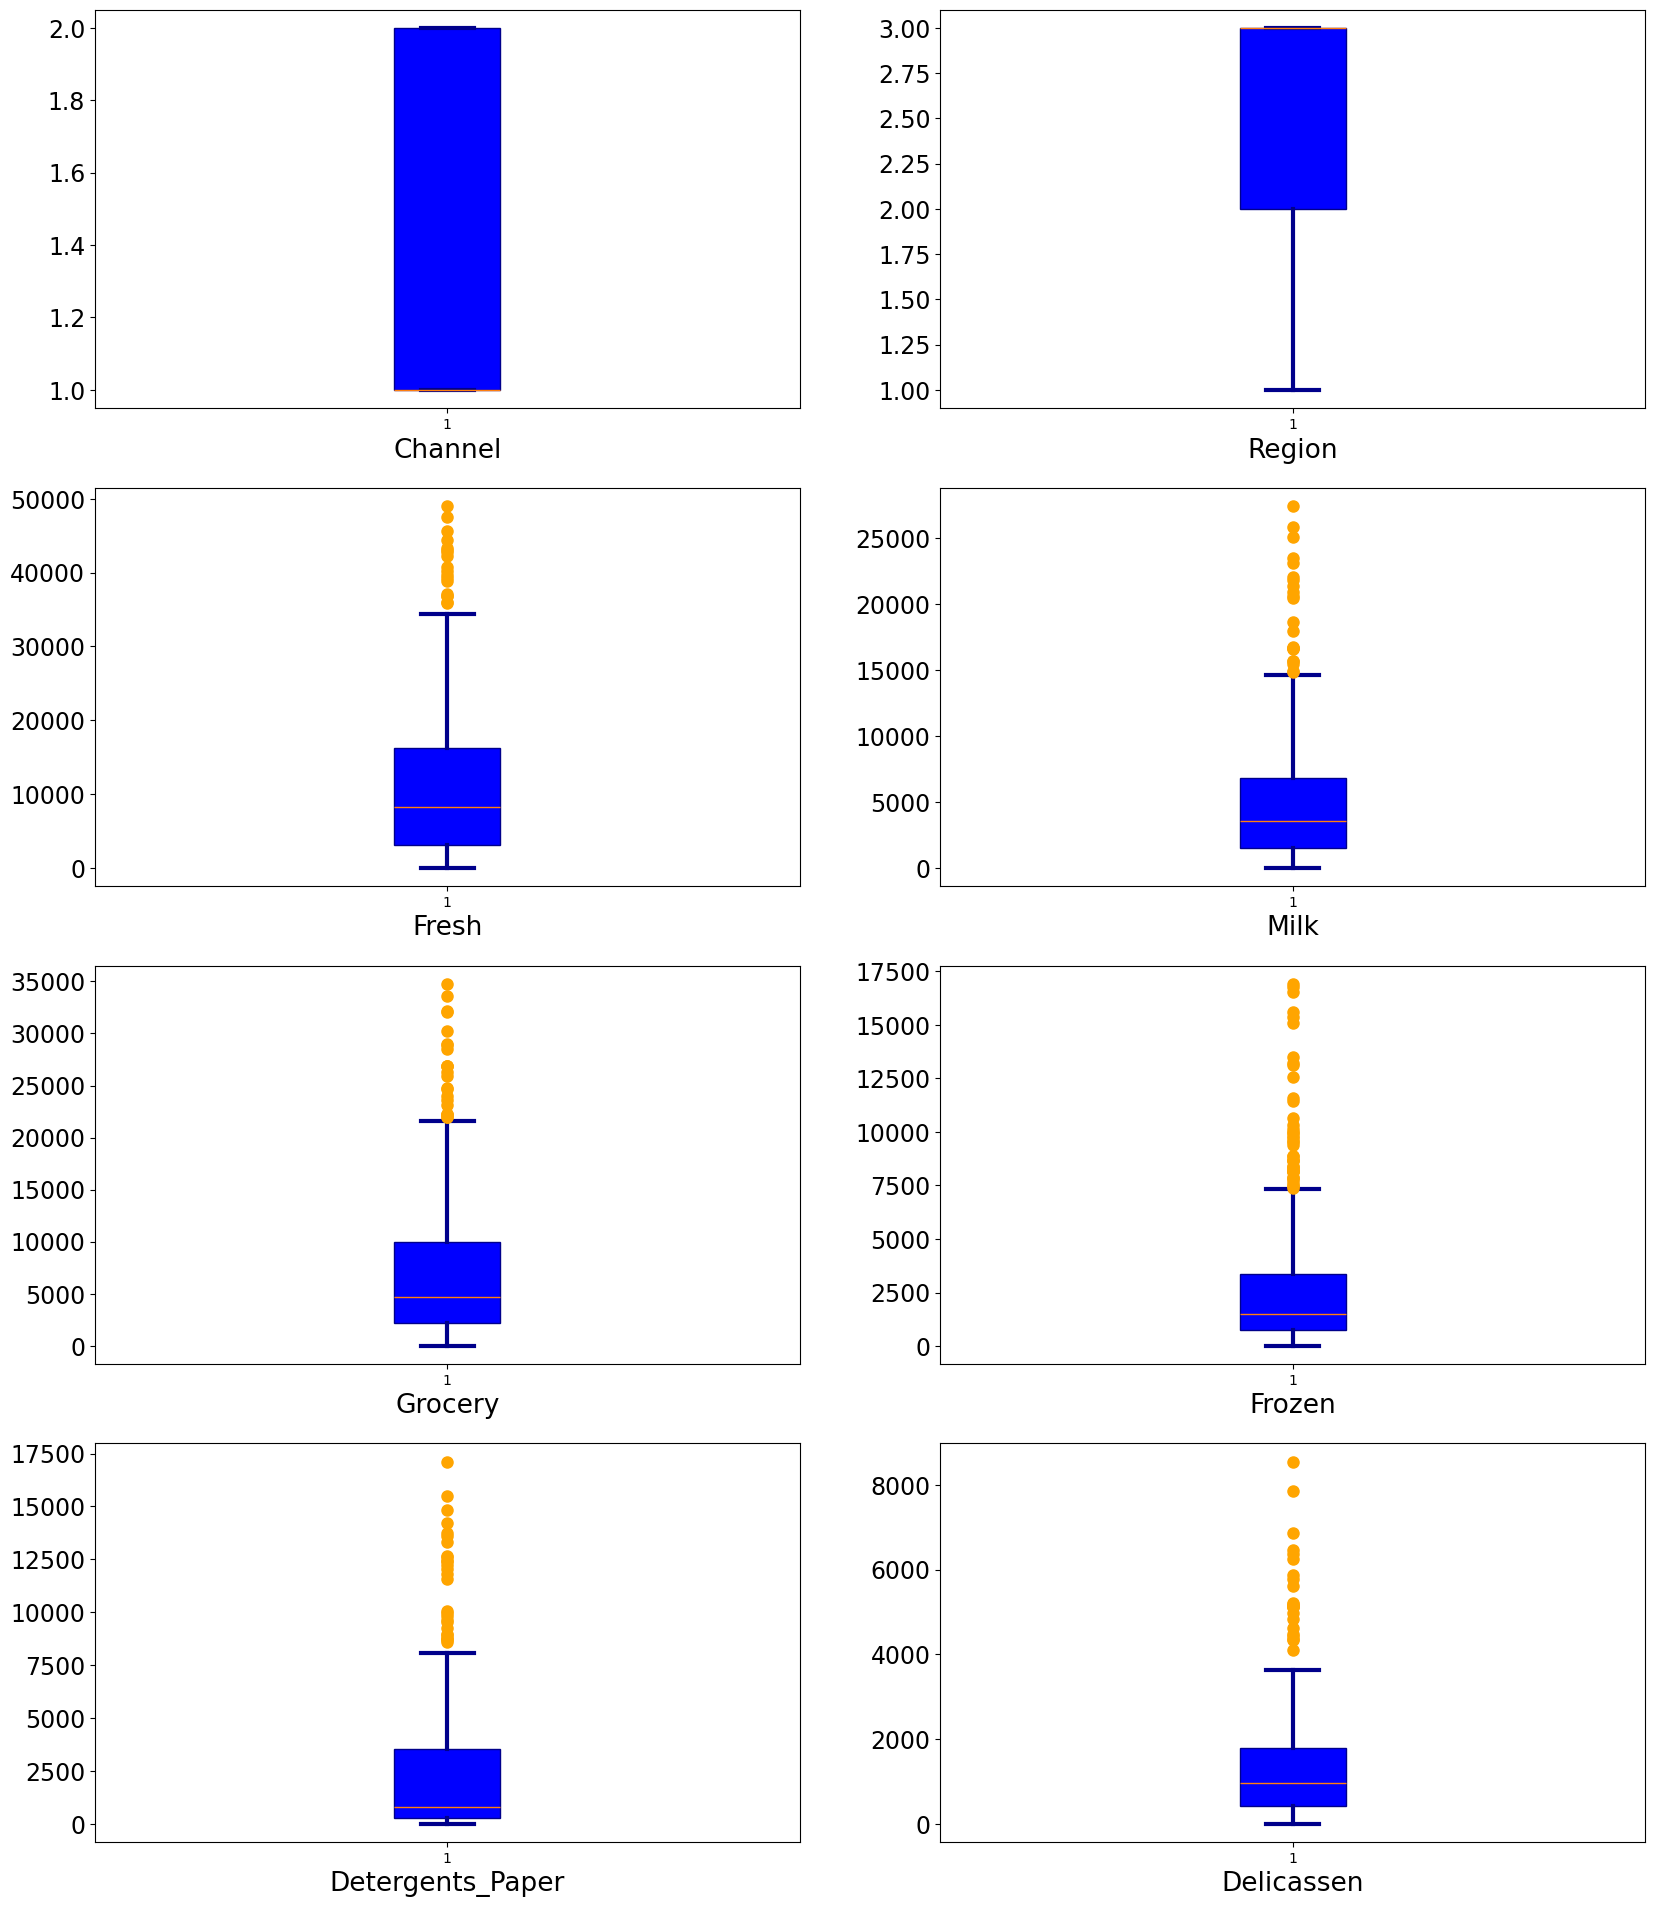

In [28]:
def median_imputation_outliers(df):
    numeric_columns = df.select_dtypes(include="number").columns
    z_scores = stats.zscore(df[numeric_columns])
    df[numeric_columns] = df[numeric_columns].where(z_scores < 3)
    df.fillna(df[numeric_columns].median(),inplace=True)
median_imputation_outliers(df)

show_boxplot_distribution(df)

Categorical Interpretation:
Channel and Region are label-encoded, but their numerical values don’t inherently represent magnitude or order. For example, the encoded values for 'Region' do not imply that 'Region=3' is inherently closer to 'Region=2' than to 'Region=1'. To avoid misleading the model by assuming an artificial order or distance between categories, one-hot encoding is employed. One-hot encoding creates binary features for each category, representing their presence or absence in the data. This approach accurately captures the categorical nature of these variables without introducing spurious relationships between them."

In [29]:
df = pd.get_dummies(df, columns=['Channel', 'Region'], dtype='int')

Some variables have greater ranges which could mimic variable weights when using minkowski or other arithmetic based distance calculations. In order to avoid that effect, normalising is done. After normalising each feature contributes proportionally to the distance calculation, preventing any single feature from dominating.

In [30]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,0.258174,0.350184,0.217253,0.011187,0.156044,0.156195,0.0,1.0,0.0,0.0,1.0
1,0.143783,0.355801,0.274943,0.102818,0.192207,0.207441,0.0,1.0,0.0,0.0,1.0
2,0.129433,0.319254,0.220788,0.140878,0.205235,0.917398,0.0,1.0,0.0,0.0,1.0
3,0.270322,0.041617,0.121245,0.377590,0.029444,0.208845,1.0,0.0,0.0,0.0,1.0
4,0.460905,0.195317,0.206818,0.230259,0.103640,0.606295,0.0,1.0,0.0,0.0,1.0


## 1.2. Data Visualization (10 Pts)

* Visualize the distribution of features
* Plot a correlation heatmap to analyze their relationships.
* Comment on any findings

Visualising the distribution of features after normalization

Now, ranges of variables do not differ remarkably due to normalization. There are still outliers according to the IQR method, but they might be clustered outside of the whiskers; not to miss possible clusters, handling 'too extreme' and 'lonely' data points is done.

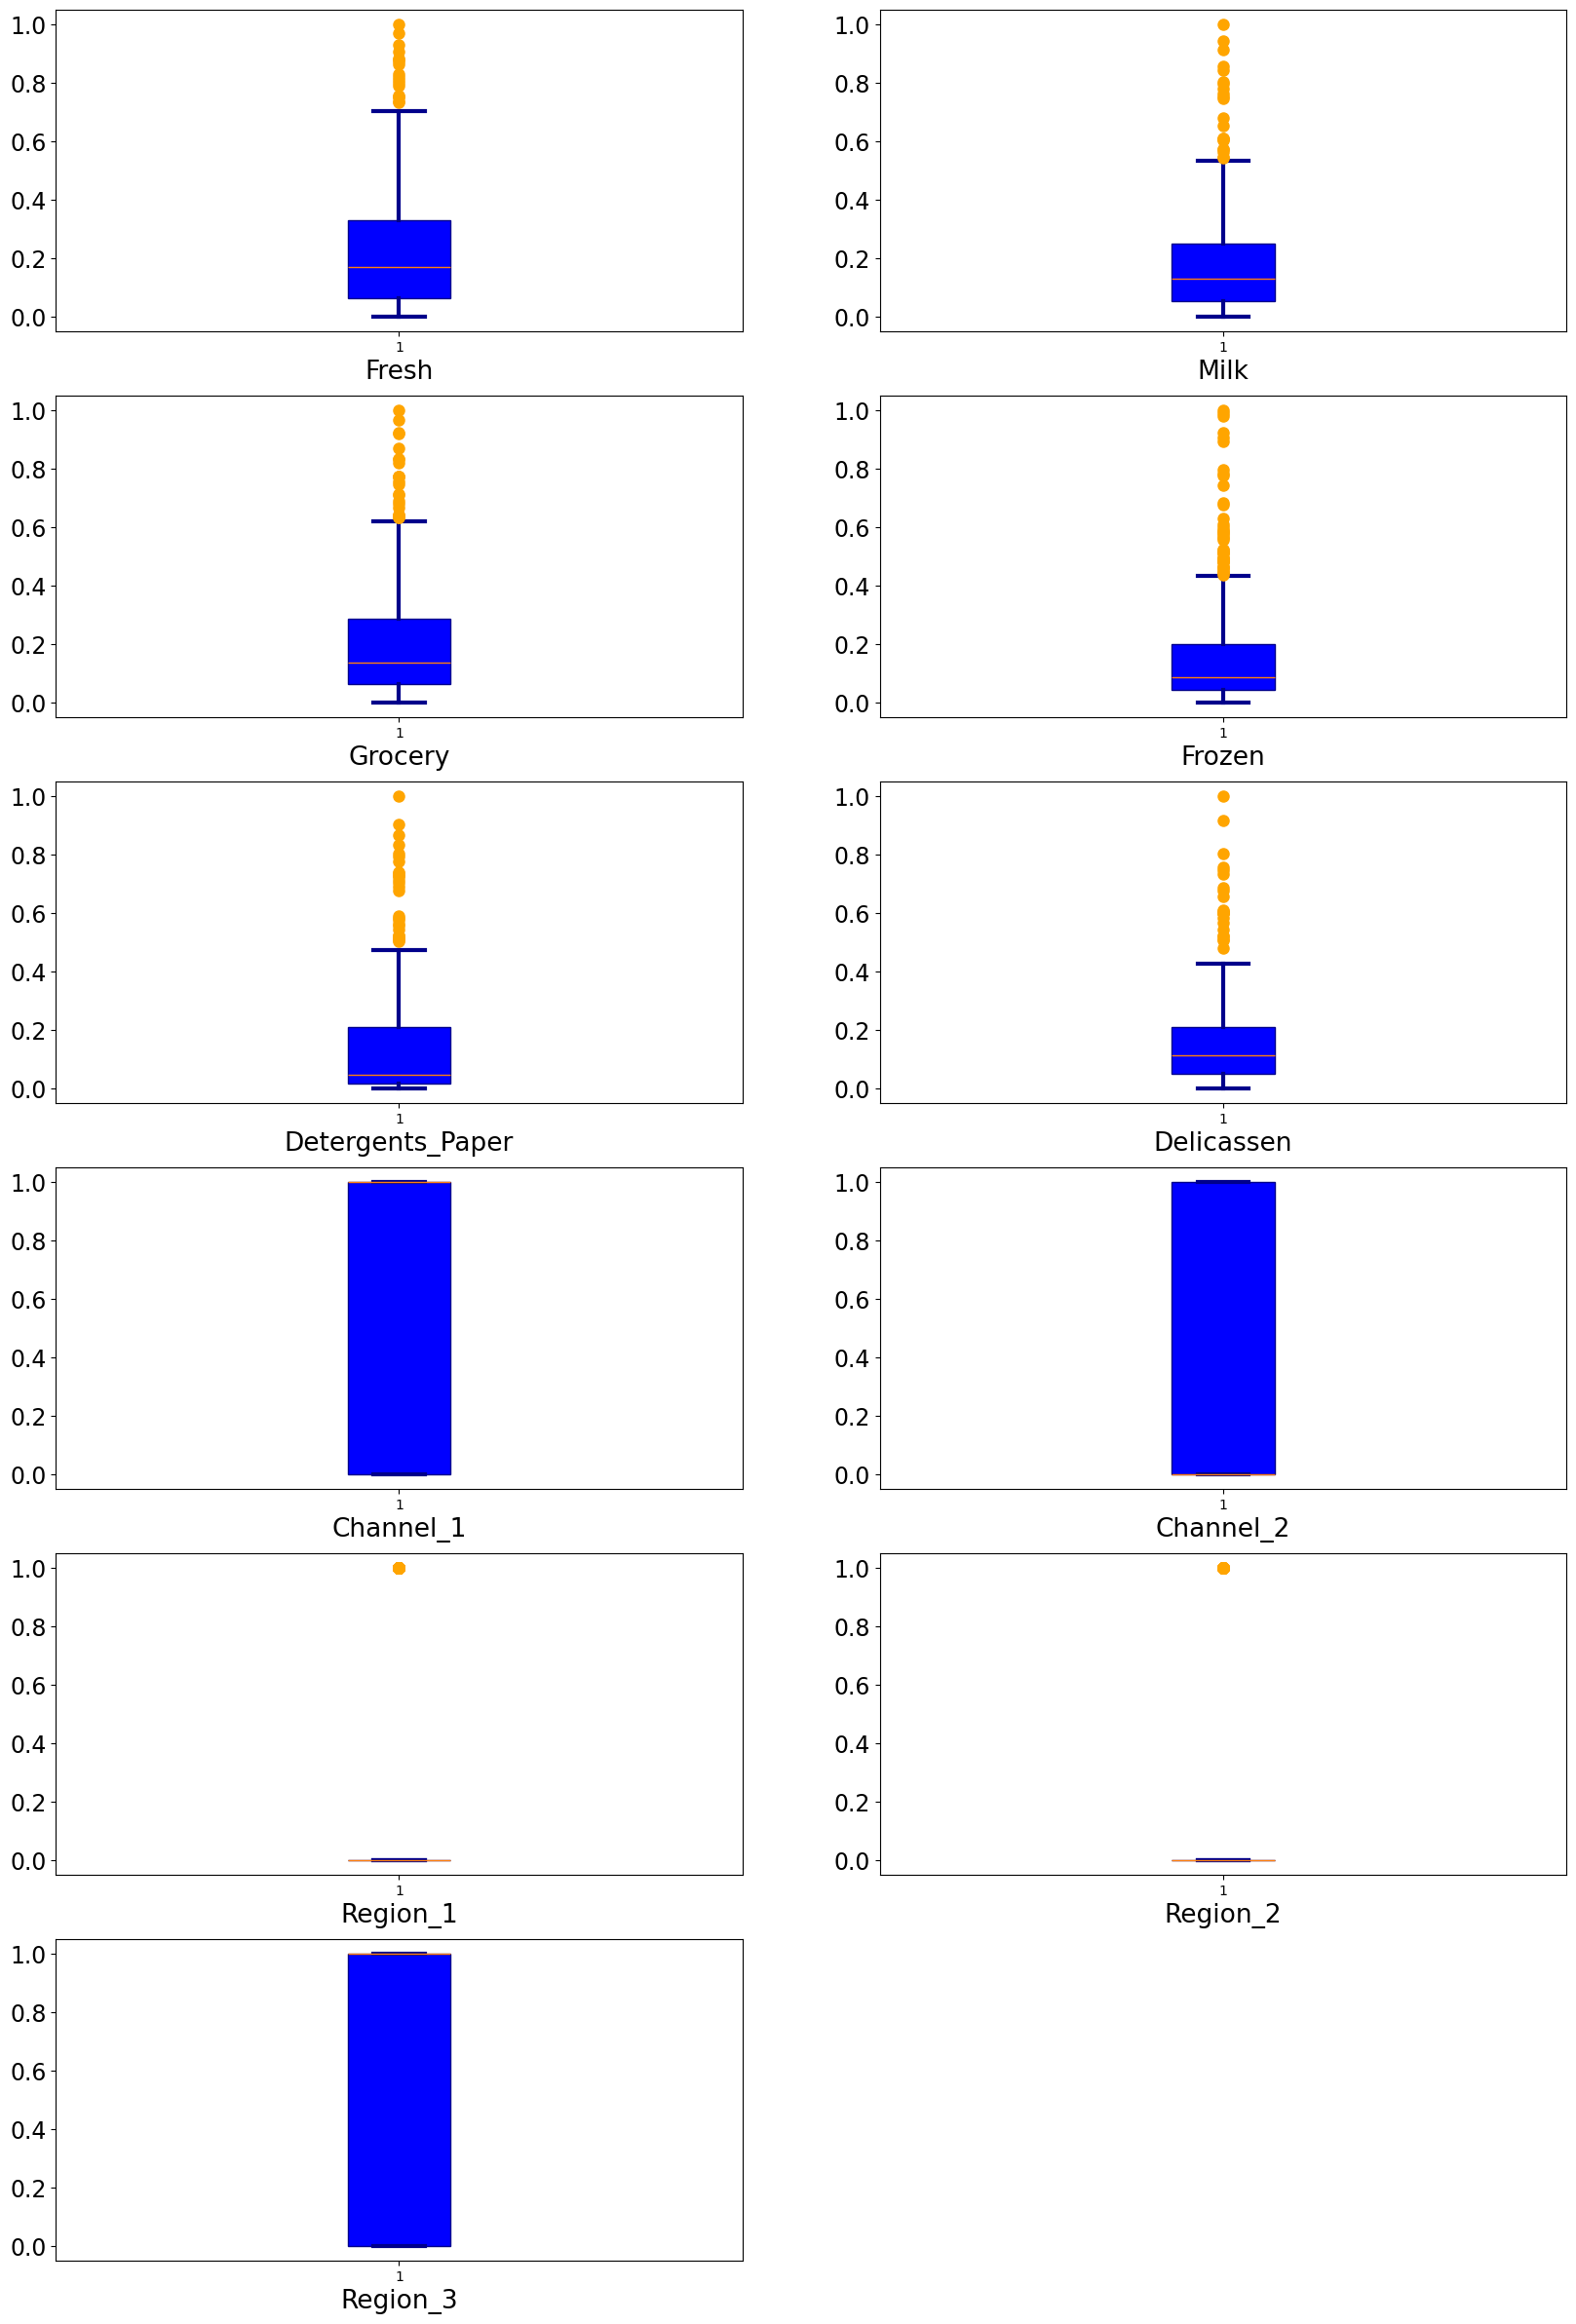

In [31]:
show_boxplot_distribution(df)

#### Findings
- Channel 2 clients has greater spending on 'Grocery' , 'Frozen', 'Detergents_Paper' than Channel 1 clients.
- Clients spend more on 'Milk', tend to spend more on 'Grocery'.
- Clients spend more on 'Detergents_Paper', tend to spend more on 'Grocery' and 'Milk'.
- Strongly correlated features could be grouped into clusters in a dimensionality reduction or clustering task (e.g., PCA, K-means). 

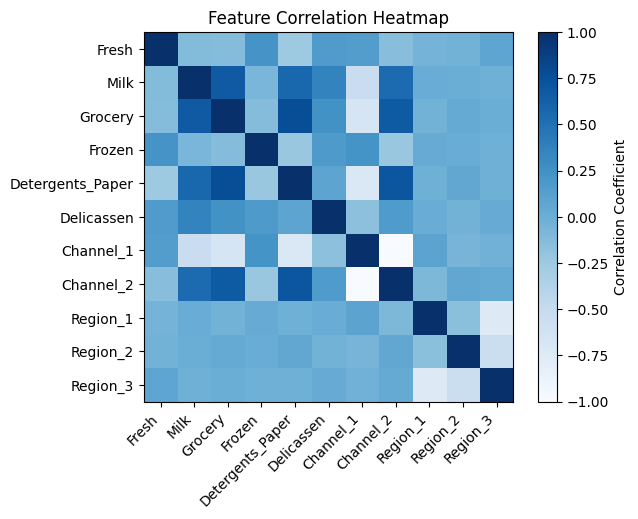

In [32]:
correlation_matrix = df.corr()
plt.figure()

plt.imshow(correlation_matrix, cmap='Blues', interpolation='none')
plt.colorbar(label='Correlation Coefficient')
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title("Feature Correlation Heatmap")

plt.show()

# **PART- 2: Clustering on the Original Dataset (30 points)**



## 2.1 K-Means Clustering on the Original Dataset (15 points)

* Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.


#### What to look?
- Steep Decline: Initially, as the number of clusters (k) increases, the distortion (WCSS) decreases rapidly. This represents the steep part of the curve.
- Change in Slope: At around k = 7, the rate of decrease in distortion starts to slow down considerably. This is where the "elbow" or bend in the curve is observed.
- Gradual Decrease: After the elbow, the distortion continues to decrease, but at a much slower pace.

Therefore, based on the visual inspection of the graph, the elbow is located around k = 7, suggesting that 7 could be a suitable number of clusters for this dataset.

NOTE: The decrease amount from 6 to 7 can be misleading. 6 is one of the strong candidates.

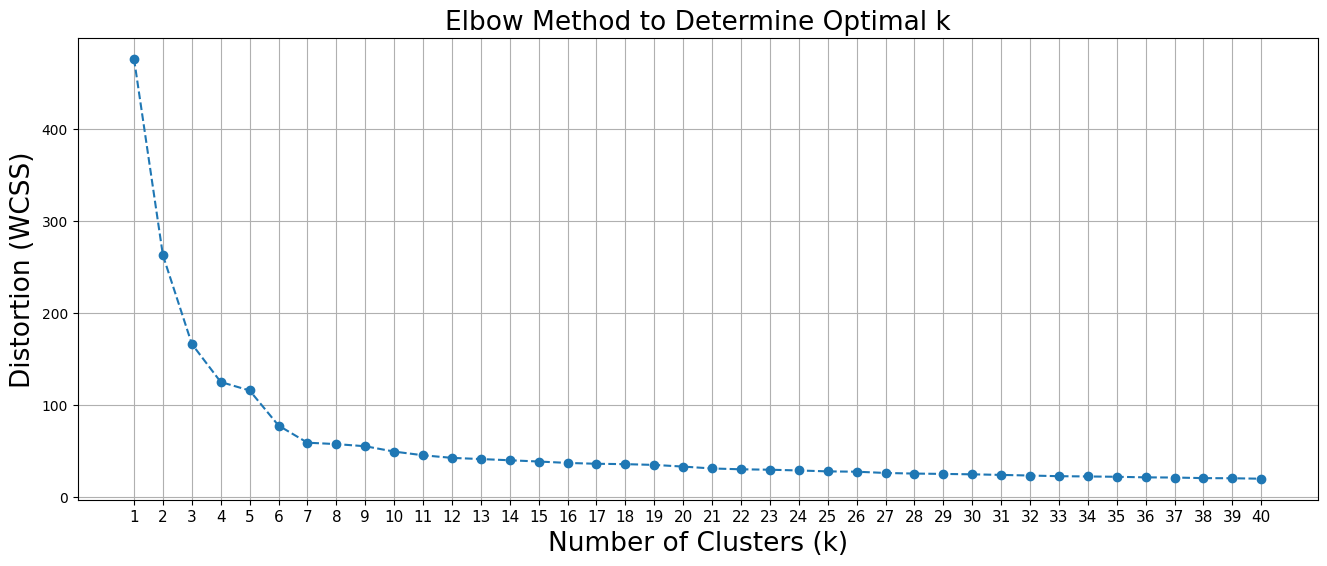

In [33]:
def plot_elbow_method_graph(df, k_values = range(1, 41)):
    wcss = []
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=212)
        kmeans.fit(df)
        wcss.append(kmeans.inertia_)
    
    plt.figure(figsize=(16, 6))
    plt.plot(k_values, wcss, marker='o', linestyle='--')
    plt.title('Elbow Method to Determine Optimal k', fontsize = 19)
    plt.xlabel('Number of Clusters (k)', fontsize = 19)
    plt.xticks(range(1, len(k_values)+1), fontsize = 11)
    plt.ylabel('Distortion (WCSS)', fontsize = 19)
    plt.grid(True)
    plt.show()

plot_elbow_method_graph(df)

In these graphs, clustering is not visible for any of single variable. Data points in different clusters commonly have same values or are in the same range of values which avoids showing any clustering according to variables. It could be possible to clustering occurs with relation of a couple of variables. Model could catch this relation but visualizing this relation is not very easy when there are more than 3 variables, applying PCA and dimensionally reduction can help; moreover, it can also provide better results of cluster identification.  

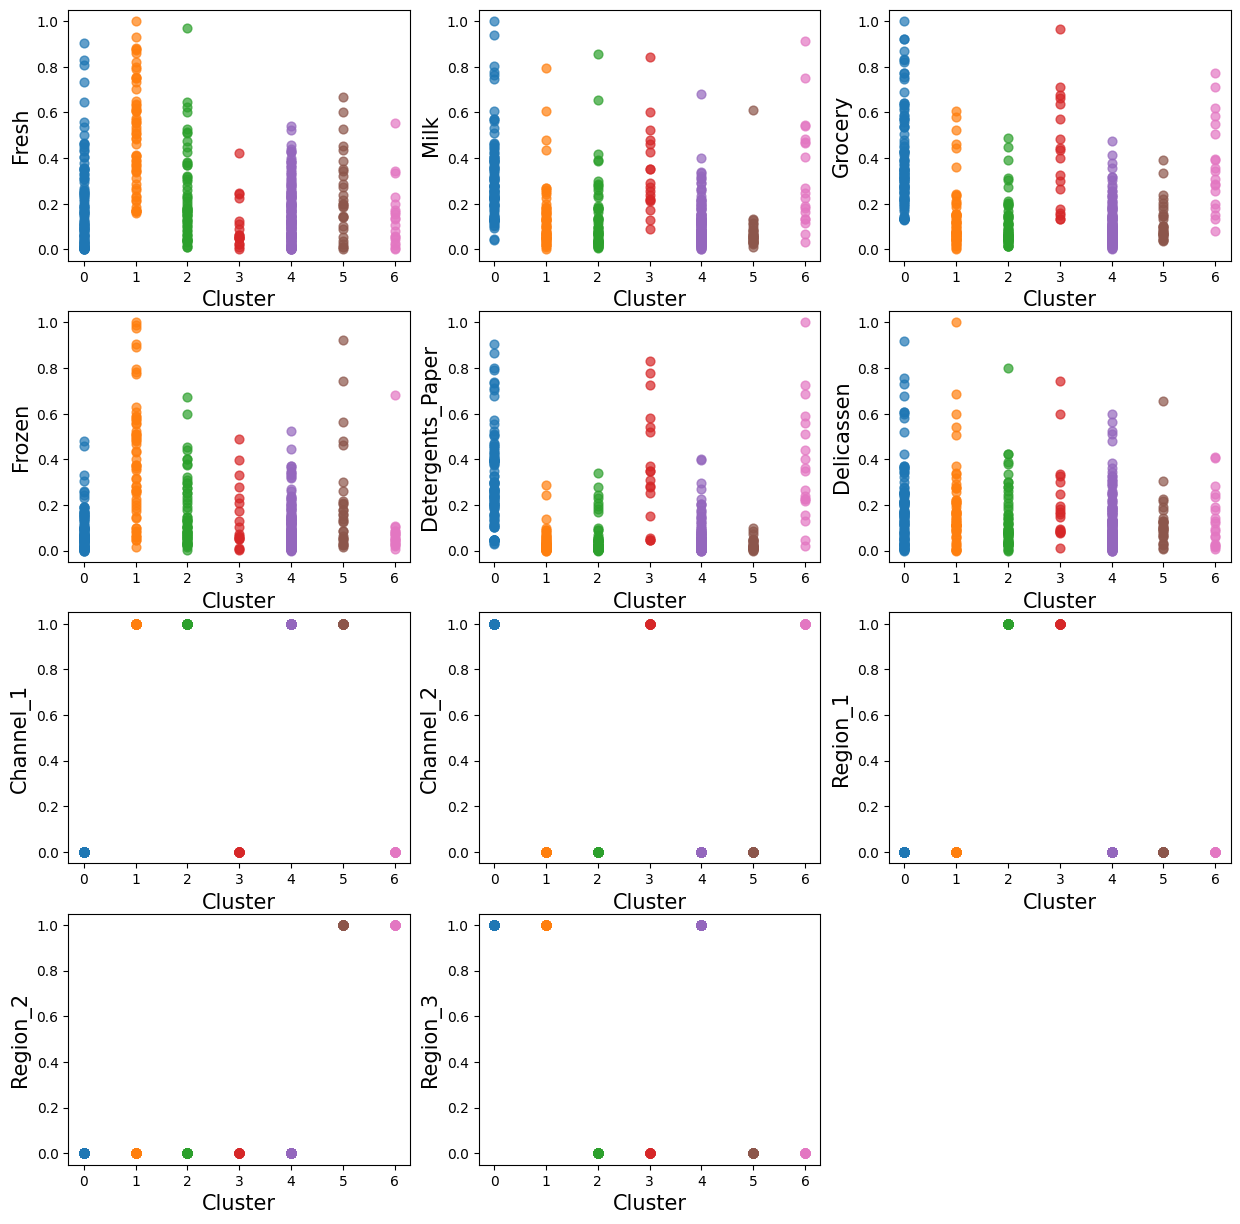

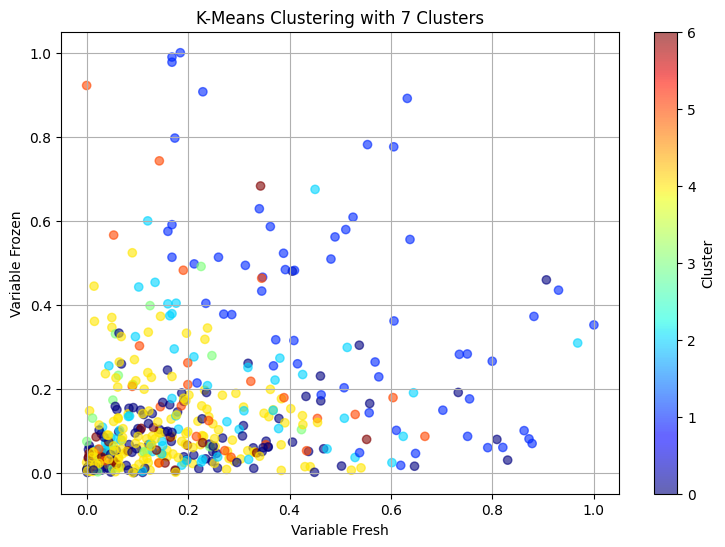

In [34]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=212)
cluster_labels = kmeans.fit_predict(df)
clustered_df = df.copy()
clustered_df['Cluster'] = cluster_labels

def show_clusters(clustered_df):
    numeric_columns = clustered_df.select_dtypes(include='number').columns.tolist()
    numeric_columns.remove('Cluster')
    
    plt.figure(figsize=(15,15))
    for i, col in enumerate(numeric_columns, 1):
        plt.subplot((len(numeric_columns) + 3) // 3, 3, i)
        for cluster in range(k):
            cluster_points = clustered_df[clustered_df['Cluster'] == cluster]
            plt.scatter(
                cluster_points['Cluster'], cluster_points[col],
                label=f'Cluster {cluster}', s=40, alpha=0.7
            )
            plt.xlabel("Cluster", fontsize =15)
            plt.ylabel(col, fontsize =15)
    plt.show()
    
show_clusters(clustered_df)

plt.figure(figsize=(9, 6))
plt.scatter(clustered_df['Fresh'], clustered_df['Frozen'], c=cluster_labels, cmap='jet', alpha=0.6)
plt.title(f'K-Means Clustering with 7 Clusters')
plt.xlabel('Variable Fresh')
plt.ylabel('Variable Frozen')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

## 2.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset (15 points)


* Apply HAC on the dataset, visualize the dendrogram. Then, comment on whether the dendrogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

The results say there can be {ward:6, complete:8, average:7, single:10}. 
- Ward: Minimizes the variance within clusters. It tends to produce clusters of similar size. 
- Complete: Uses the maximum distance between any two points in the two clusters to determine the distance between clusters. This method tends to produce compact, spherical clusters.
- Single: Uses the minimum distance between any two points in the two clusters. This method can be sensitive to outliers and may result in elongated or chain-like clusters. 
- Average: Uses the average distance between all pairs of points in the two clusters. This method is generally considered more robust than single or complete linkage. 

### Overall
The average method exactly matches with the number founded. Other results are also close to the 7. However, the y values of the red lines are selected by eye and also for all graphs just by shifting line a little bit upward, 6 cluster can be obtained(Auto-coloring supports there are 6 clusters at three of the graphs). HAC and k-Means do not give exact results. This should be emphasized and considered by the researcher.  

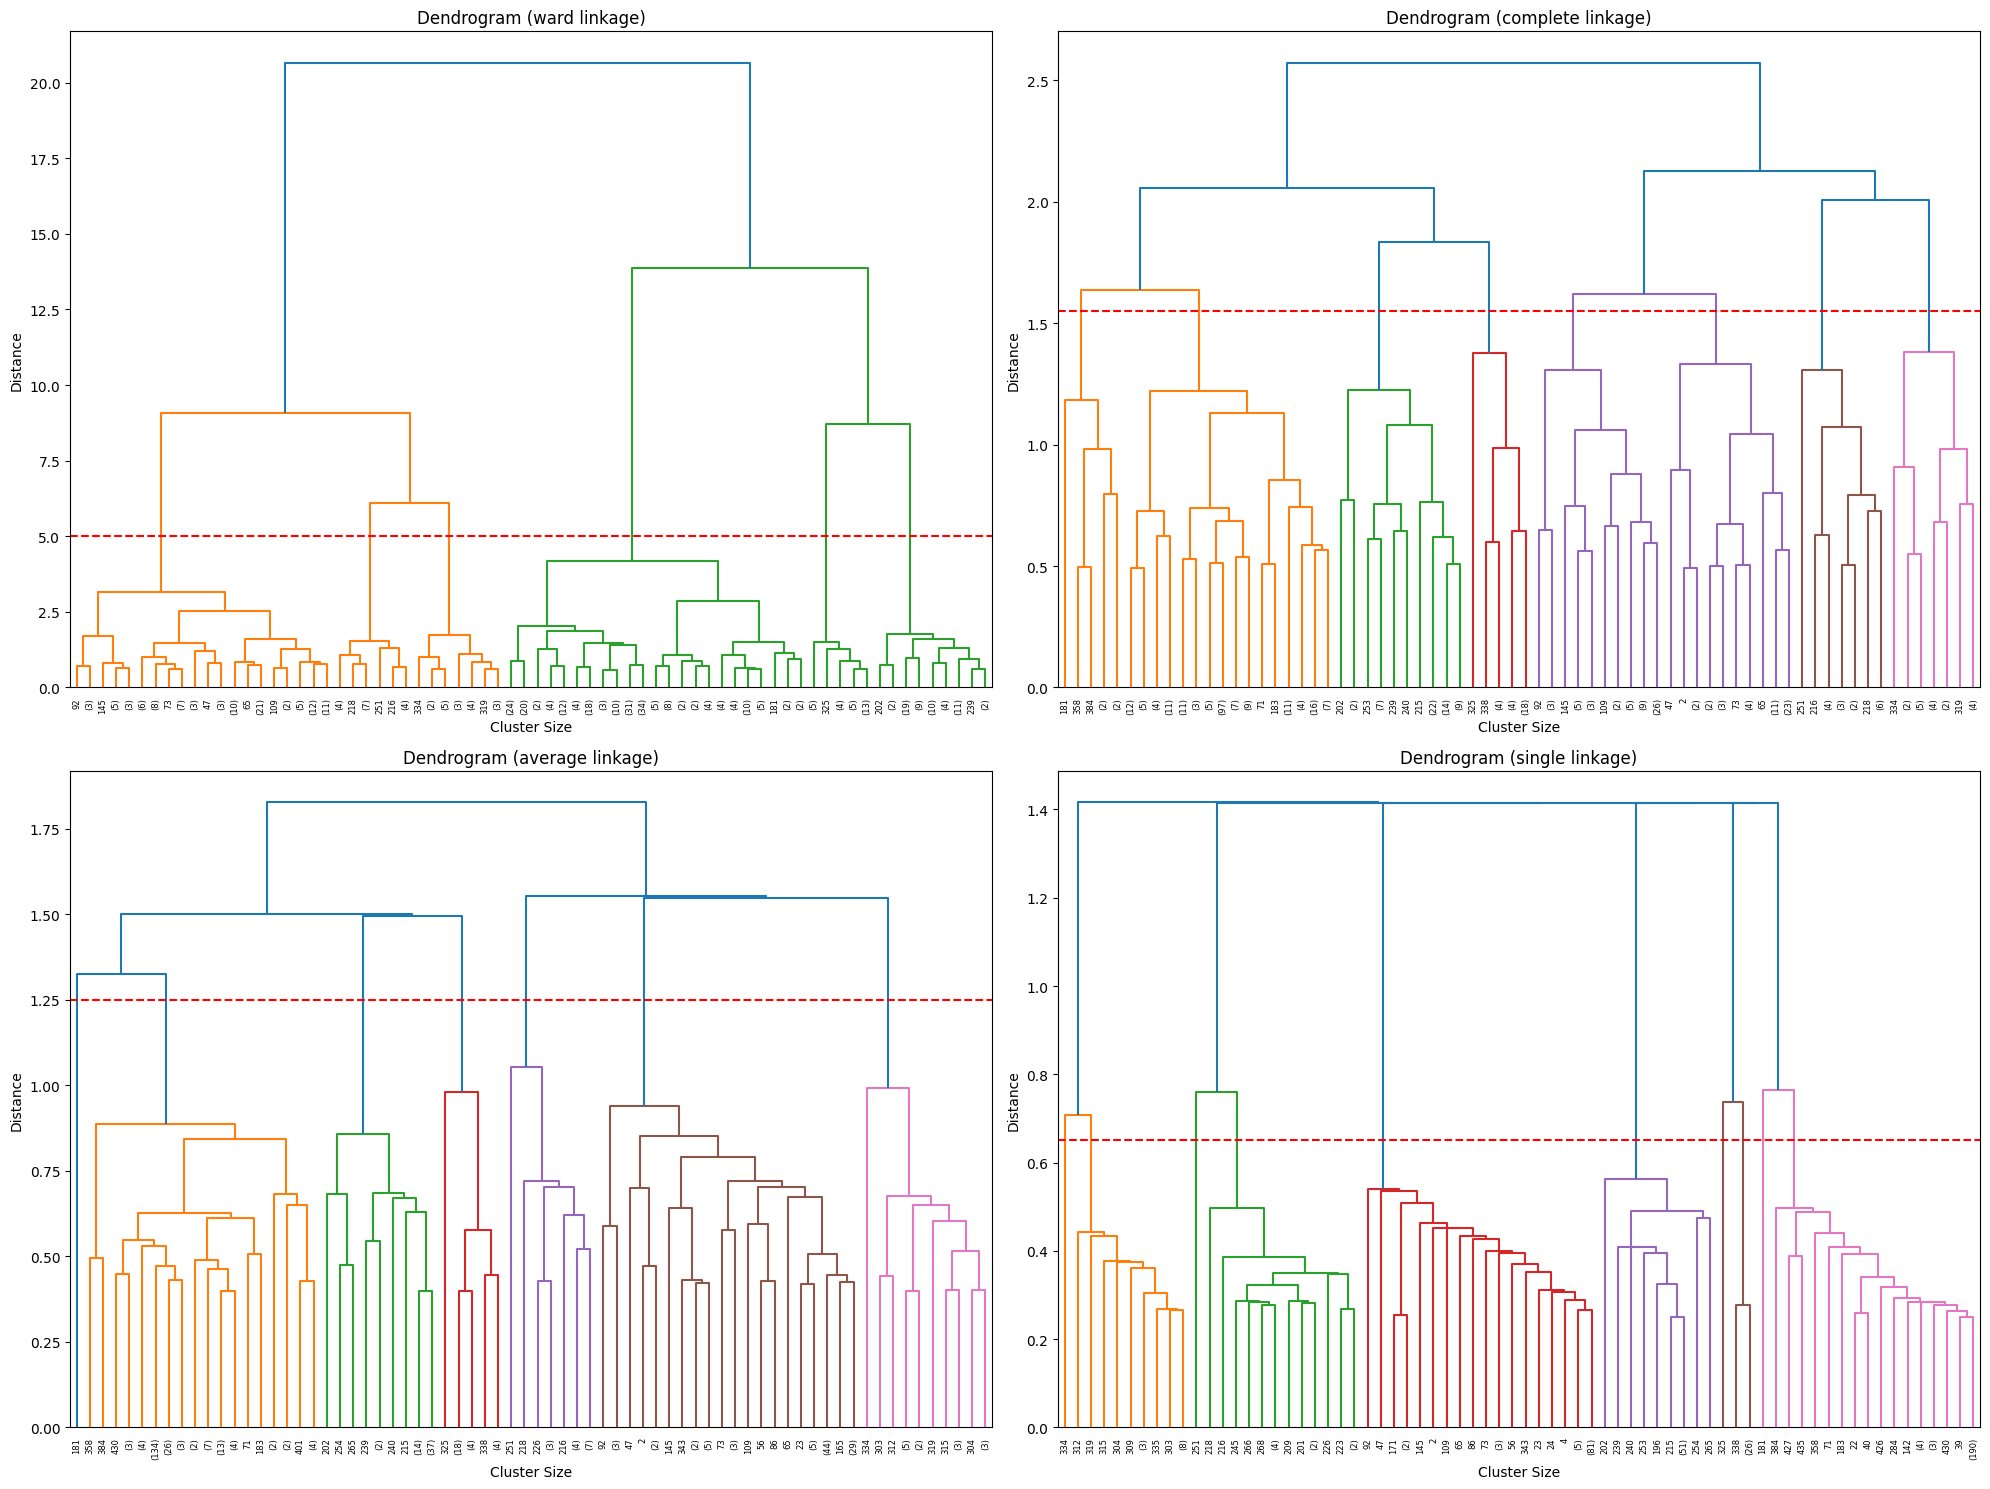

In [35]:
linkage_methods = ['ward', 'complete', 'average', 'single']

plt.figure(figsize=(20, 15))
for i, method in enumerate(linkage_methods, 1):
    plt.subplot(2, 2, i)
    Z = linkage(df, method=method)  # Compute linkage matrix
    dendrogram(Z, truncate_mode='lastp', p=70)  # Dendrogram visualization

    # Add horizontal line for 4 clusters
    if (i==1) : plt.axhline(y=5, color='r', linestyle='--')
    elif(i==2) : plt.axhline(y=1.55, color='r', linestyle='--')
    elif(i==3) : plt.axhline(y=1.25, color='r', linestyle='--')
    else: plt.axhline(y=0.65, color='r', linestyle='--')

    plt.title(f"Dendrogram ({method} linkage)")
    plt.xlabel("Cluster Size")
    plt.ylabel("Distance")

plt.tight_layout()
plt.show()

# **PART- 3: Dimensionality Reduction (30 points)**

### *What is Dimensionality Reduction and Why is it Used?*

Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### *Principal Component Analysis (PCA)*

PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance. **Process:**

* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.


***You can use scikit-learn***




## 3.1. Apply PCA (15 Pts)

* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.
* Comment on any findings

In [36]:
# Normalised dataframe
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_1,Channel_2,Region_1,Region_2,Region_3
0,0.258174,0.350184,0.217253,0.011187,0.156044,0.156195,0.0,1.0,0.0,0.0,1.0
1,0.143783,0.355801,0.274943,0.102818,0.192207,0.207441,0.0,1.0,0.0,0.0,1.0
2,0.129433,0.319254,0.220788,0.140878,0.205235,0.917398,0.0,1.0,0.0,0.0,1.0
3,0.270322,0.041617,0.121245,0.377590,0.029444,0.208845,1.0,0.0,0.0,0.0,1.0
4,0.460905,0.195317,0.206818,0.230259,0.103640,0.606295,0.0,1.0,0.0,0.0,1.0


After applying PCA and visualizing, there are 6 clusters appears to be. The study done above were also giving the signals of there can be 6 clusters. 

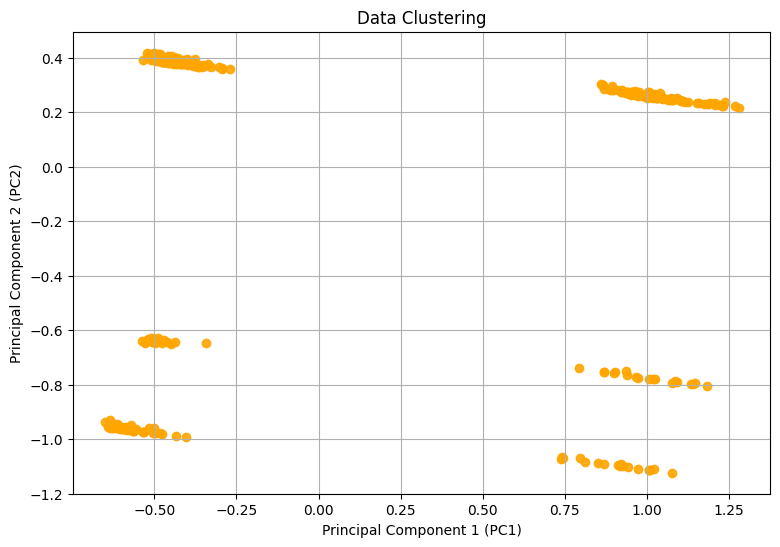

In [37]:
# Apply PCA
pca = PCA()
pca2_df = pca.fit_transform(df)

# Visualize the data with the first two principal components
plt.figure(figsize=(9, 6))
plt.scatter(pca2_df[:, 0], pca2_df[:, 1], c='orange', alpha=0.9)
plt.title('Data Clustering')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.grid()
plt.show()

After increasing number of principal components, the variance explained is increasing cumulatively until reaching 1 which is the actual variance. Explaining 90% of the variance is a good choice using 4 principal component, but result can reach almost 95% just by increasing PC number by 1 to the 5.

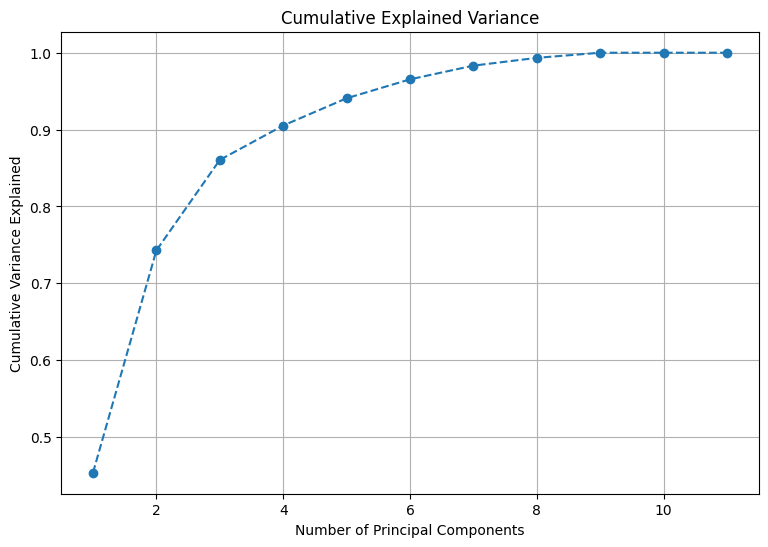

Number of Components -> Explained Variance Ratio
1 -> 45.3%
2 -> 74.3%
3 -> 86.1%
4 -> 90.5%
5 -> 94.1%
6 -> 96.5%
7 -> 98.3%
8 -> 99.3%
9 -> 100.0%
10 -> 100.0%
11 -> 100.0%


In [38]:

# Visualize variance explained by each component
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(9, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.show()

# Choose the number of components that explain at least 95% of the variance
print("Number of Components -> Explained Variance Ratio")
for i in range(len(explained_variance_ratio)):
    print(f"{i+1} -> {explained_variance_ratio[i]*100:.1f}%")   

## 3.2. K-means Clustering with PCA (15 Pts)
* Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

In [39]:
# Reduce dataset to 5 principal components
pca = PCA(n_components=5)
pca5_df = pca.fit_transform(df)

After PCA, 6 number of clusters stands out as elbow. 6 is coming from the graph and also it can be derived from the studies above. 

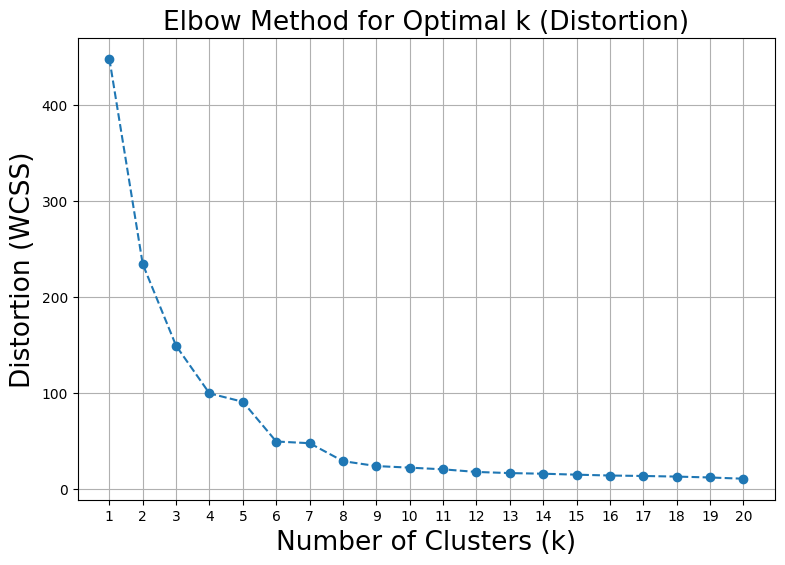

In [40]:
distortion = []
k_range = range(1, 21)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca5_df)
    distortion.append(kmeans.inertia_)

plt.figure(figsize=(9, 6))
plt.plot(k_range, distortion, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (Distortion)', fontsize=19)
plt.xlabel('Number of Clusters (k)', fontsize=19)
plt.ylabel('Distortion (WCSS)', fontsize=19)
plt.xticks(k_range)
plt.grid()
plt.show()

In [41]:
# Apply k-Means where k=6
kmeans = KMeans(n_clusters=6, random_state=214)
cluster_labels = kmeans.fit_predict(pca5_df)

As visible graph at the bottom, clustering is successful. The 6 clusters are identified and labeled correctly.

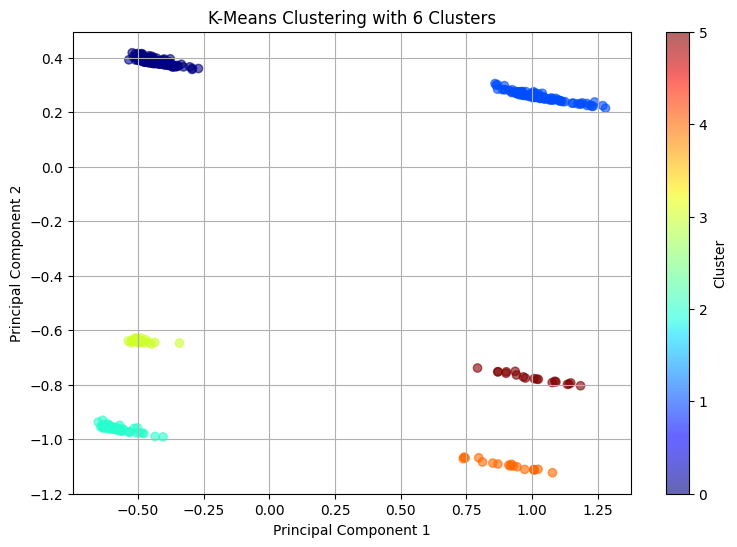

In [42]:
# Visualize clusters using the first two principal components
plt.figure(figsize=(9, 6))
plt.scatter(pca5_df[:, 0], pca5_df[:, 1], c=cluster_labels, cmap='jet', alpha=0.6)
plt.title(f'K-Means Clustering with 6 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()


# **PART- 4: Evaluate the Clustering Results (20 points)**

* Evaluate and compare the clustering results (k means with and without PCA) using the Silhouette Coefficients.

* Identify which clustering method and dataset version (original vs. PCA-reduced) resulted in the best clustering.

* Discuss the impact of dimensionality reduction (PCA) on clustering performance.

* Highlight any differences in performance between K-Means and Agglomerative Clustering.

<font color='orange'> When PCA is not used visualization gets really difficult and lead to astrayed cluster number selections.

### 1) PCA:
- PCA improved clustering performance for both K-Means and Agglomerative Clustering by reducing noise and highlighting the most significant features.
- PCA-reduced datasets allowed clustering algorithms to form more compact and well-separated clusters.

### 2) Difference Between K-Means and Agglomerative Clustering:
- With the original dataset, K-Means outperformed Agglomerative Clustering (Silhouette scores: 0.674 vs. 0.539).
- With the PCA-reduced dataset, Agglomerative Clustering slightly outperformed K-Means (Silhouette scores: 0.755 vs. 0.743).
- K-Means works well for compact and well-separated clusters. However, it struggles with irregularly shaped or overlapping clusters. However in this dataset, clusters were not irregularly shaped which caused similar results.
- It is also important to note that the k-means method is sensitive to the initialization of centroids. Other random_state values may affect the result and cause it to be slightly above or below the AC method.
- Requires the number of clusters (k) to be specified upfront. This can be challenging if the optimal number of clusters is not known.

<br>
<br>

## Impact of Dimensionality Reduction
PCA significantly enhanced clustering performance for both methods.
By reducing the dataset to its top 5 components, PCA eliminated redundant information and made the data more suitable for clustering.
Clustering algorithms performed better with fewer, more meaningful dimensions, avoiding the curse of dimensionality.

<br>
<br>

## Computational Complexity
+ K-Means:
Computationally efficient, with a time complexity of O(n⋅k⋅t), where n is the number of data points, k is the number of clusters, and t is the number of iterations.
+ Agglomerative Clustering:
Computationally expensive, with a time complexity of O(n^2⋅log(n)). This makes it less suitable for large datasets.

<br>
<br>

## Conclusion
Agglomerative Clustering with PCA yielded the best-defined clusters overall.
PCA effectively improved clustering performance by simplifying the data structure and retaining variance.
While K-Means performed well on the original dataset, Agglomerative Clustering benefitted more from the PCA transformation.

In [43]:
# K-Means Clustering without PCA
kmeans_original = KMeans(n_clusters=6, random_state=214)
cluster_labels_original = kmeans_original.fit_predict(df)
silhouette_original = silhouette_score(df, cluster_labels_original)

# K-Means Clustering with PCA
kmeans_pca = KMeans(n_clusters=7, random_state=214)
cluster_labels_pca = kmeans_pca.fit_predict(pca5_df)
silhouette_pca = silhouette_score(pca5_df, cluster_labels_pca)

# Agglomerative Clustering without PCA
agglo_original = AgglomerativeClustering(n_clusters=7)
cluster_labels_agglo_original = agglo_original.fit_predict(df)
silhouette_agglo_original = silhouette_score(df, cluster_labels_agglo_original)

# Agglomerative Clustering with PCA
agglo_pca = AgglomerativeClustering(n_clusters=6)
cluster_labels_agglo_pca = agglo_pca.fit_predict(pca5_df)
silhouette_agglo_pca = silhouette_score(pca5_df, cluster_labels_agglo_pca)

print("Silhouette Coefficients:")
print()
print(f"-K-Means without PCA: {silhouette_original:.3f}")
print(f"-K-Means with PCA:    {silhouette_pca:.3f}")
print(f"-Agglomerative Clustering without PCA: {silhouette_agglo_original:.3f}")
print(f"-Agglomerative Clustering with PCA:    {silhouette_agglo_pca:.3f}")


Silhouette Coefficients:

-K-Means without PCA: 0.674
-K-Means with PCA:    0.743
-Agglomerative Clustering without PCA: 0.539
-Agglomerative Clustering with PCA:    0.755


# SUBMIT FORMAT

* **<-zip>**
  - **studentID_name_surname_hw5.ipynb**


# PLAGIARISM

All work on assignments must be done individually. You are encouraged to discuss the given assignments with your classmates, but these discussions should be carried out in an abstract way. That is, discussions related to a particular solution to a specific probem (either in actual code or in pseudocode) will not be tolerated. In short, turning in someone else’s work (including work available on the internet), in whole or in part, as your own will be considered as a violation of academic integrity. Please note that the former conditions also hold for the material attained using AI tools, including ChatGPT, GitHub Copilot, etc.